In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Some code to beautify the plots
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [2]:
def gkbd(A, b, k = 20):
    
    m,n = A.shape
    
    U = np.zeros((m,k+1), dtype = 'd')
    V = np.zeros((n,k+1), dtype = 'd')
    
    alpha = np.zeros((k+1,), dtype = 'd')
    beta  = np.zeros((k+1,), dtype = 'd')
    
    #Initialize vectors
    beta[0] = np.linalg.norm(b)
    u = b/beta[0];     U[:,0] = np.copy(u)

    v = np.dot(A.T,u)
    alpha[0] = np.linalg.norm(v)
    v /= alpha[0]
    V[:,0] = np.copy(v)
     
    for j in range(k):
        u = np.dot(A,v) - alpha[j]*u
        
        beta[j+1] = np.linalg.norm(u)
        u        /= beta[j+1]
        U[:,j+1]   = np.copy(u)
        
        v          = np.dot(A.T,u) - beta[j+1]*v 
        alpha[j+1] = np.linalg.norm(v)
        v         /= alpha[j+1]
        V[:,j+1]   = np.copy(v)
        
        
    return U, V, alpha,beta

### Verifying all the Lanczos relations

||V^TV - I||_2  1.0180953043660444e-12
||U^T U -I||_2 6.04602882420423e-13
|| U_k^TAV_k - Bk||_2  8.141422035276008e-12
|| AV_k - U_kBk - beta_{k+1}u_{k+1}e_k^T||_2  2.145307562013083e-14


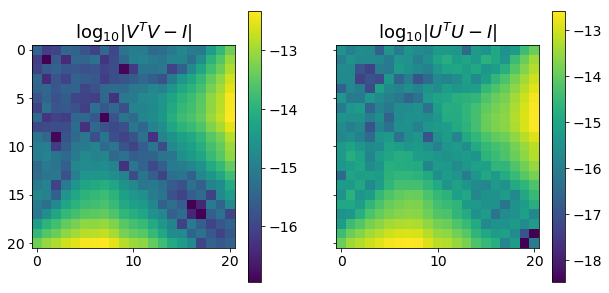

In [3]:
#Test the Lanczos bidiagonalization process
A = np.random.randn(120,100)
b = np.random.randn(120)

k = 20
U, V, alpha,beta = gkbd(A, b, k = k)
B = np.diag(alpha[:-1],0) + np.diag(beta[1:-1],-1)

vkp1 = V[:,-1]
ukp1 = U[:,-1]

e = np.zeros((k,), dtype = 'd')
e[-1] = 1.


Vk = V[:,:-1]
Uk = U[:,:-1]

### Compute various errors
print "||V^TV - I||_2 ", np.linalg.norm(np.dot(V.T,V) - np.eye(k+1),2)
print "||U^T U -I||_2" , np.linalg.norm(np.dot(U.T,U) - np.eye(k+1),2)
print "|| U_k^TAV_k - Bk||_2 ", np.linalg.norm(np.dot(Uk.T, np.dot(A,Vk))- B,2)
print "|| AV_k - U_kBk - beta_{k+1}u_{k+1}e_k^T||_2 ", np.linalg.norm(np.dot(A,Vk) - np.dot(Uk,B) - beta[-1]*np.outer(ukp1,e))


### Show the loss in orthogonality
f, (ax1, ax2) = plt.subplots(1,2, sharey = True)
O1 = np.dot(V.T,V) - np.eye(k+1) + 1.e-16
c1 = ax1.imshow(np.log10(np.abs(O1)))
f.colorbar(c1, ax = ax1)
ax1.set_title('$\log_{10}|V^TV - I|$', fontsize = 18)
O2 = np.dot(U.T,U) - np.eye(k+1) + 1.e-16
c2= ax2.imshow(np.log10(np.abs(O2)))
ax2.set_title('$\log_{10}|U^TU - I|$', fontsize = 18)
f.colorbar(c2, ax = ax2)

### Approximating the singular values

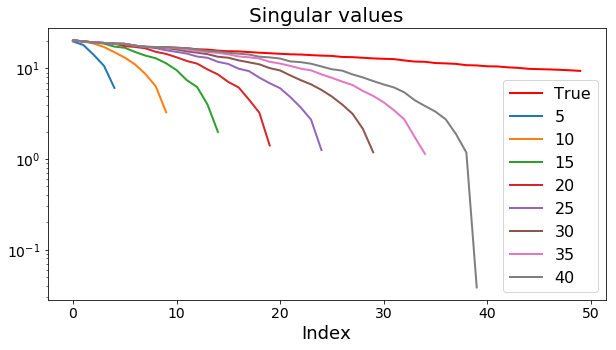

In [4]:
k = 40
U, V, alpha,beta = gkbd(A, b, k = k)
B = np.diag(alpha[:-1],0) + np.diag(beta[1:-1],-1)


u,s,vh = np.linalg.svd(A)

plt.semilogy(s[:50], 'r-', linewidth = 2.0)

for k in range(5,45,5):
    Bk = B[:k+1,:k]
    sk = np.linalg.svd(Bk, compute_uv = False, full_matrices = False)
    plt.semilogy( sk, linewidth = 2.0)
    
labels = [str(i) for i in range(5,45,5)]
labels.insert(0,'True')
plt.xlabel('Index', fontsize = 18)
plt.title('Singular values', fontsize = 20)
plt.legend(tuple(labels), fontsize = 16)

### Illustrating the semiconvergence behavior

In [5]:
from testproblems import gravity

A,b,xtrue = gravity(256, example = 0)

# Adding noise
noise = 0.01*np.linalg.norm(b, np.inf)*np.random.randn(b.size) 
bn = b + noise
print "Noise to signal ratio", np.linalg.norm(noise)/np.linalg.norm(b)

Noise to signal ratio 0.013678204299385014


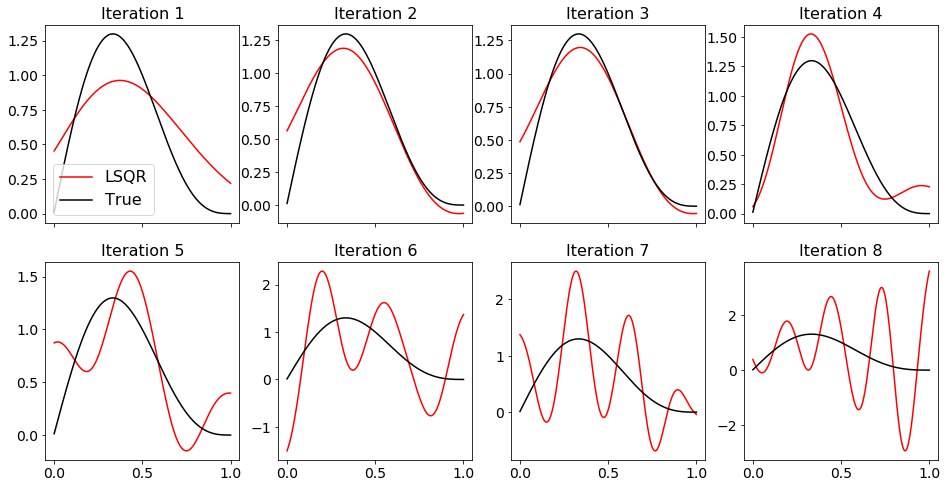

In [6]:
k = 20
U, V, alpha,beta = gkbd(A, bn, k = k)

e = np.zeros((k+1,), dtype = 'd')
e[0] = beta[0]

err = np.zeros((8,), dtype = 'd')
msf = err*0
reg = err*0

t = np.linspace(0,1,b.size)
f, axarray = plt.subplots(2,4, sharex = True, figsize = (16,8))
for j, ax in enumerate(axarray.flat):
    Uk = U[:,:j+1]
    Vk = V[:,:j+1]
    Lk = np.diag(alpha[:j+1],0) + np.diag(beta[1:j+1],-1)
    
    
    z = np.zeros((1,j+1), dtype = 'd')
    z[-1] = beta[j+2]
    Bk1 = np.vstack((Lk,z))
    
    y,_,_,_ = np.linalg.lstsq(Bk1,e[:j+2], rcond = None)
    x = np.dot(Vk,y)
    
    msf[j] = np.linalg.norm(np.dot(A,x)-bn)
    reg[j] = np.linalg.norm(x)
    
    
    err[j] =  np.linalg.norm(x-xtrue)/np.linalg.norm(xtrue)
    ax.plot(t,x,'r-',t,xtrue,'k-')
    ax.set_title('Iteration ' + str(j+1), fontsize = 16)
    if j == 0: ax.legend(('LSQR', 'True'), fontsize = 16)


## Illustration of the semiconvergence behavior

Text(0.5,1,'Illustration of semiconvergence')

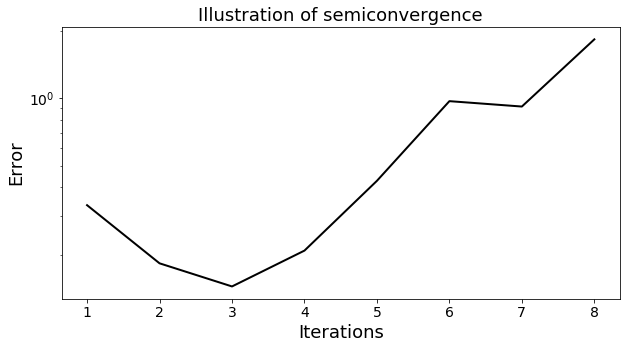

In [7]:
plt.figure()
plt.semilogy( range(1,9), err, 'k-', linewidth = 2.)
plt.xlabel('Iterations', fontsize = 18)
plt.ylabel('Error', fontsize = 18)
plt.title('Illustration of semiconvergence', fontsize = 18)